In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_extraction.extract_trial as extract_trial
import utils.cosine_similarity as cosine_similarity
import data_extraction.get_indices as get_indices
import data_extraction.trial_list_filters as trial_list_filters
import analysis.conditioned_player_choice as conditioned_player_choice

### Get positions and headangles

In [2]:
def get_player_position_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the position of the player at trial start.
        Takes the player_id and a single trial.'''
    
    trial = extract_trial.extract_trial(trial=trial, trial_list=trial_list, trial_index=trial_index)
    assert isinstance(trial, pd.DataFrame)


    # get slice onset index, referenced to trial start
    slice_onset = trial[trial['eventDescription'] == globals.SLICE_ONSET]
    slice_onset_index = slice_onset.index - trial.index[0]
    
    # access the x and y locations stored in the player location dictionary indexed at the current player id
    x_coordinate = trial[globals.PLAYER_LOC_DICT[player_id]['xloc']].iloc[slice_onset_index]
    y_coordinate = trial[globals.PLAYER_LOC_DICT[player_id]['yloc']].iloc[slice_onset_index]

    player_position_coordinates = np.vstack([x_coordinate, y_coordinate])

    return player_position_coordinates


In [3]:
def get_player_headangle_vector_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the head angle of the player at trial start.
        Takes the player_id and a single trial. '''
    
    trial = extract_trial.extract_trial(trial, trial_list, trial_index)
    assert isinstance(trial, pd.DataFrame)

    # get slice onset index, referenced to trial start
    slice_onset = trial[trial['eventDescription'] == globals.SLICE_ONSET]
    slice_onset_index = slice_onset.index - trial.index[0]

    # find the euler angle for the rotation around the y (Unity vertical) axis
    y_rotation = trial[globals.PLAYER_ROT_DICT[player_id]['yrot']].iloc[slice_onset_index]
    head_angle = np.deg2rad(y_rotation)
    
    # convert euler angle into euclidean vector
    x_component = np.sin(head_angle)
    z_component = np.cos(head_angle)
    head_angle_vector = np.vstack([x_component, z_component])

    return head_angle_vector



In [4]:
def calculate_vector_norms_for_timepoint(self_other_vector, self_head_angle_vector):
    ''' Return the norm of the head angle vector and the self to other vector
        Returns scalar head_angle_vector_norm and self_to_other_vector_norm '''

    # find norm of headangle vector
    head_angle_vector_norm = np.linalg.norm(self_head_angle_vector)
    
    # find norm of the self-to-other vector
    self_to_other_vector_norm = np.linalg.norm(self_other_vector)

    return head_angle_vector_norm, self_to_other_vector_norm

In [5]:
def calculate_angle_to_opponent_from_positions_and_headangle(self_position, other_position,
                                                                 self_head_angle_vector):
    ''' Use cosine similarity (angle between vectors, length invariant) to return the angle
        between the vector of self head angle and vector from self to other.
        Takes the self position, other position, and self head angle vector. '''

    # calculate euclidean vector from Self to Other
    # self and other position are size 2 vectors (x,y)
    self_other_vector = other_position - self_position

    # dot product between head angle vector and self-other vector
    dot_product_vectors = np.dot(self_other_vector.flatten(), self_head_angle_vector.flatten())

    # vector norms for both self_other_vector and self_head_angle_vector 
    (self_other_vector_norm,
      self_head_angle_vector_norm) = calculate_vector_norms_for_timepoint(self_other_vector, 
                                                                          self_head_angle_vector)
    
    # cosine similarity between the two vectors
    vector_cosine_similarity = cosine_similarity.calculate_cosine_similarity_two_vectors(dot_product_vectors,
                                                                                         self_other_vector_norm,
                                                                                         self_head_angle_vector_norm)
    
    # get angle from cosine similarity
    theta = cosine_similarity.calculate_angle_from_cosine_similarity(vector_cosine_similarity)

    return theta
    



In [6]:
def get_two_player_positions_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the Self position and Other position for a trial, at slice onset'''

    opponent_id = 1 if player_id == 0 else 0

    self_position = get_player_position_slice_onset(player_id, trial, trial_list, trial_index)

    other_position = get_player_position_slice_onset(opponent_id, trial, trial_list, trial_index)

    return self_position, other_position

In [7]:
# Umbrella function to find trial start angle-to-opponent for a single player for one trial
def get_angle_of_opponent_from_player_trial(player_id, trial=None, trial_list=None, trial_index=None):
    ''' For a single trial, return the angle from player head direction to opponent player.
        Takes the player_id of Self, and the trial. '''

    # find self and other positions 
    self_position, other_position = get_two_player_positions_slice_onset(player_id, trial=trial,
                                                                        trial_list=trial_list,
                                                                        trial_index=trial_index)

    # find general self head angle vector
    self_head_angle_vector = get_player_headangle_vector_slice_onset(player_id, trial=trial,
                                                                    trial_list=trial_list,
                                                                    trial_index=trial_index)

    # calculate angle from cosine similarity between self_head_angle_vector and self_to_other vector
    # (self_to_other_vector is calculated in this function as the difference between Self and Other position)
    theta = calculate_angle_to_opponent_from_positions_and_headangle(self_position,
                                                                    other_position,
                                                                    self_head_angle_vector)
  
    return theta
    

In [8]:
# MAIN Umbrella function to repeat trial start angle identification for a single player for one session
def get_angle_of_opponent_from_player_session(player_id, trial_list):
    ''' For all trials in a session, return the angle from player head direction to opponent player.
        Takes the player_id of Self (persistent throughout session) and the trial list. '''
    
    # get the angle for each trial in session, for a persistent Self player_id
    orientation_angle_to_other_session = np.full(len(trial_list), np.nan,  dtype=float)
    for i, trial in enumerate(trial_list):
    
        theta = get_angle_of_opponent_from_player_trial(player_id, trial=trial)

        orientation_angle_to_other_session[i] = theta

    return orientation_angle_to_other_session
    

In [9]:
def get_other_visible_session(orientation_angle_to_other_session, current_fov):
    ''' Return a boolean array for whether Other is visible to Self at trial start.
        Takes the angle of orientation from Self to Other as an array for the session (in radians)
        and the visible fov for this dataset (in degrees) '''

    # convert orientation_angle_to_other_session from radians to degrees to match current_fov
    orientation_angle_to_other_session = np.rad2deg(orientation_angle_to_other_session)

    # if Other is visible, the angle to orient Other into Self central view must be less than half the current
    # field-of-view.
    # At the threshold, Other enters visual periphery
    other_visible_session = orientation_angle_to_other_session < current_fov/2

    return other_visible_session


### Final, flexible function to get probabilities and original list-relative indices for trial outcomes for any given set of conditions, across and entire set of sessions

In [ ]:
def probability_trial_outcome_given_conditions_all_sessions(trial_lists, inferred_choice, current_fov,
                                                            chosen_wall_index=None, visible_wall_index=None,
                                                            wall_sep=None, trial_type=globals.HIGH_LOW,
                                                            debug=False):
    ''' Returns two dictionaries: probabilities and trial_data.
        probabilities contains the probability of trial outcome given conditions for each session and player,
        for other visible and other not visible conditions.
        Arrays are of shape num_sessions, num_players.
        trial_data contains the trial indices (relative to the original trial list for each session) of the 
        numerator and denominator trials that feed into the final probability calculation for that player and session.
        Lists contain 2 nested lists, one for each player.
        Takes a list of trial lists (one for each session), inferred choice, fov. 
        Optionally takes chosen_wall_index and visible_wall_index to specify choosing either High or Low,
        or see High or Low at the beginning of the session, respectively. Default is to not select on these.
        '''

    # initialize lists to store probabilities and indices for both visible and not visible conditions
    probabilities = {
        'other_visible': np.full((len(trial_lists), 2), np.nan),  # two columns for two players
        'other_not_visible': np.full((len(trial_lists), 2), np.nan)
    }

    trial_data = {
        'denominator_other_visible': [[],[]],
        'denominator_other_not_visible': [[],[]],
        'numerator_other_visible': [[],[]],
        'numerator_other_not_visible': [[],[]]
    }
    
    # loop through each session in the trial list
    for trial_list_index, trial_list in enumerate(trial_lists):

        # filter trial list for specified trial type (e.g., HIGH_LOW)
        trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_list_filtered = [trial_list[i] for i in trial_indices]

        # also filter trial list by specific wall separation if specified
        if wall_sep is not None:
            trial_indices = get_indices.get_trials_with_wall_sep(trial_list_filtered, wall_sep=wall_sep)
            trial_list_filtered = [trial_list_filtered[i] for i in trial_indices]


        # iterate over both player IDs (0 and 1)
        for player_id in [0,1]:            
            # calculate probabilities and filtered indices for both visibility conditions (Other visible, Other not visible)
            (prob_visible,
            filtered_indices_visible,
            filtered_choice_indices_visible) = conditioned_player_choice.probability_trial_outcome_given_conditions(
                                                trial_list_filtered, player_id, 
                                                visible_wall_index, chosen_wall_index,
                                                other_visible=True, wall_initial_vis_only=True,
                                                inferred_choice=inferred_choice, current_fov=current_fov,
                                                inverse_other_visible=False,
                                                return_trial_indices=True, debug=False)
            (prob_not_visible,
            filtered_indices_not_visible,
            filtered_choice_indices_not_visible) = conditioned_player_choice.probability_trial_outcome_given_conditions(
                                                    trial_list_filtered, player_id, 
                                                    visible_wall_index, chosen_wall_index,
                                                    other_visible=True, wall_initial_vis_only=True,
                                                    inferred_choice=inferred_choice, current_fov=current_fov,
                                                    inverse_other_visible=True,
                                                    return_trial_indices=True, debug=False)
            
            # store probabilities for each player in the respective column (player 0 -> col 0, player 1 -> col 1)
            probabilities['other_visible'][trial_list_index, player_id] = prob_visible
            probabilities['other_not_visible'][trial_list_index, player_id] = prob_not_visible

            # append filtered indices to the nested list for each player (player 0 -> index 0, player 1 -> index 1)
            trial_data['denominator_other_visible'][player_id].append(filtered_indices_visible)
            trial_data['denominator_other_not_visible'][player_id].append(filtered_indices_not_visible)
            trial_data['numerator_other_visible'][player_id].append(filtered_choice_indices_visible)
            trial_data['numerator_other_not_visible'][player_id].append(filtered_choice_indices_not_visible)
                
        
    # Final probabilities for the wall choice
    wall_choice_probabilities = {
        'other_visible': probabilities['other_visible'],
        'other_not_visible': probabilities['other_not_visible']
    }

    
    return wall_choice_probabilities, trial_data

### Rewrite and turn into flexible function

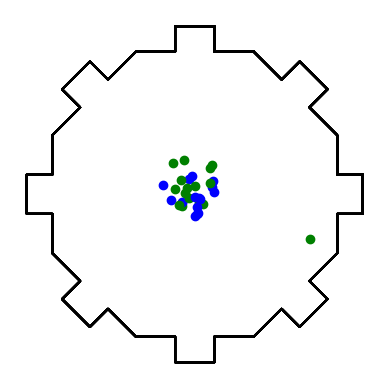

In [ ]:
# # plot trial start positions for self and other, combining both players in a session, 
# # only for trials with Other visible and H visible at trial start
# # TODO rewrite cleanly to avoid 
# # TODO repeat for the list of trials where Other is NOT visible
# # TODO see 250123 octagon meeting notes for how to polish these plots and best use them

# chosen_walls_session = np.zeros(len(filtered_trail_list_a_list[0]))  # unused for this analysis

# # trial lists
# filtered_trail_list_a_list          # all trials with Other and High visible
# filtered_trial_list_choice_a_list   # all trials with Other not viisble and High visible

# # starting with player 0, the first index 
# player_id = 0

# # Run the first trial out of the loop to generate the plotted octagon axes
# trial = filtered_trail_list_a_list[12][0]
# (_, _, 
# rotated_flipped_trial, _,
# chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial, player_id=0)
# ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=None)

# # now loop the rest of player_id 0 trials
# for i, trial in enumerate(filtered_trail_list_a_list[12][1:]):
#     (_, _, 
#     rotated_flipped_trial, _,
#     chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial, player_id=player_id)
#     ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=ax)
# # now loop all player_id 1 trials
# player_id = 1
# for i, trial in enumerate(filtered_trail_list_a_list[13]):
#     (_, _, 
#     rotated_flipped_trial, _,
#     chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial, player_id=player_id)
#     ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=ax)


### Archived

In [ ]:
# umbrella function to compare probabilities of P(High | first visible) between Other visible and Other not visible

def probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list, other_visible_session, player_id,
                                                                    visible_wall_index, chosen_wall_index,
                                                                    inferred_choice, current_fov,
                                                                    inverse_other_visible=False,
                                                                    return_trial_indices=False, debug=False):
    ''' Take a trial list and filter based on opponent visibility, existence of player_id player choice,
        and whether a specific wall is initially visible. 
        Then, filter this trial list by the player choice being for a specific trial wall, and take the proportion
        of trials remaining as the probability of making this choice conditioned on our chosen filters.
        Returns probability of choosing a trial wall. 
        visible_wall_index and chosen_wall_index control wall initial visibility and player choice filters respectively.
        inverse_other_visible flag sets the filter of opponent visibility to be 'opponent not visible' if True. '''
    
    if debug:
      print(f"Next session, player_id {player_id}")

    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = trial_list_filters.filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)

    # filter trials with a retrievable choice for this player (trials only valid for analysis if we 
    # have a recorded choice for the player)
    (trial_list_filtered_player_choice_exists,
    player_choice_exists_indices) = trial_list_filters.filter_trials_retrievable_choice(trial_list_filtered_other_visible, player_id, inferred_choice)

    # filter Other initially visible with high wall initially visible
    (trial_list_filtered_high_wall_initially_visible,
    high_wall_initially_visible_indices) = trial_list_filters.filter_trials_one_wall_initially_visible(trial_list_filtered_player_choice_exists, player_id,
                                                                                     wall_index=visible_wall_index, current_fov=current_fov)

    # filter Other-visible, High initially visible, with player_choice aligning with given wall (given_wall_index)
    (trial_list_filtered_player_choice,
    player_chose_given_wall_indices) = trial_list_filters.filter_trials_player_chose_given_wall(trial_list_filtered_high_wall_initially_visible, player_id,
                                                                                inferred_choice,
                                                                                  given_wall_index=chosen_wall_index)

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = conditioned_player_choice.calculate_probability_choose_wall(trial_list_filtered_high_wall_initially_visible,
                                                                                          trial_list_filtered_player_choice)

    if debug:
      print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")
      print(f"Len player_choice_exists_indices: {len(player_choice_exists_indices)}")
      print(f"Len high_wall_initially_visible_indices: {len(high_wall_initially_visible_indices)}")
      print(f"Len player_chose_given_wall_indices: {len(player_chose_given_wall_indices)}")
      print(f"Probability player chose wall given these conditions: {probability_chose_wall}")

    if not return_trial_indices:
      return probability_chose_wall
    else:
       return probability_chose_wall, trial_list_filtered_high_wall_initially_visible, trial_list_filtered_player_choice

In [ ]:
# umbrella function to compare probabilities of P(High) between Other visible and Other not visible

def probability_chose_wall_conditioned_on_other_visibility(trial_list, other_visible_session, player_id,
                                                           chosen_wall_index, inferred_choice,
                                                           inverse_other_visible=False, debug=False):
    ''' Take a trial list and filter based on opponent visibility and existence of player_id player choice.
        Then, filter this trial list by the player choice being for a specific trial wall, and take the proportion
        of trials remaining as the probability of making this choice conditioned on our chosen filters.
        Returns probability of choosing a trial wall. 
        chosen_wall_index controls player choice filter.
        inverse_other_visible flag sets the filter of opponent visibility to be 'opponent not visible' if True. '''
    
    if debug:
      print(f"Next session, player_id {player_id}")
    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = trial_list_filters.filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)
    
    # filter trials with a retrievable choice for this player (trials only valid for analysis if we 
    # have a recorded choice for the player)
    (trial_list_filtered_player_choice_exists,
    player_choice_exists_indices) = trial_list_filters.filter_trials_retrievable_choice(trial_list_filtered_other_visible, player_id, inferred_choice)
    

    # filter Other-visible with player_choice aligning with given wall (given_wall_index)
    (trial_list_filtered_player_choice,
    player_chose_given_wall_indices) = trial_list_filters.filter_trials_player_chose_given_wall(trial_list_filtered_player_choice_exists, player_id,
                                                                                inferred_choice,
                                                                                  given_wall_index=chosen_wall_index)

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = conditioned_player_choice.calculate_probability_choose_wall(trial_list_filtered_player_choice_exists,
                                                                                          trial_list_filtered_player_choice)

    if debug:
      print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")
      print(f"Len player_choice_exists_indices: {len(player_choice_exists_indices)}")
      print(f"Len player_chose_given_wall_indices: {len(player_chose_given_wall_indices)}")
      print(f"Probability player chose wall given these conditions: {probability_chose_wall}")
    
    
    return probability_chose_wall 

In [ ]:
# umbrella function to compare probabilities of winning between Other visible and Other not visible

def probability_win_trial_conditioned_on_other_visibility(trial_list, other_visible_session, player_id,
                                                          inverse_other_visible=False, debug=False):
    ''' Take a trial list and filter based on opponent visibility..
        Then, filter this trial list by whether player player_id wins the trial, and take the proportion
        of trials remaining as the probability of winning conditioned on our chosen filters.
        Returns probability of winning. 
        inverse_other_visible flag sets the filter of opponent visibility to be 'opponent not visible' if True. '''
    
    if debug:
      print(f"Next session, player_id {player_id}")
    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = trial_list_filters.filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)
    print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")

    # filter Other-visible with player being the winner
    trigger_activators = get_indices.get_trigger_activators(trial_list_filtered_other_visible)
    this_player_wins_indices = np.where(trigger_activators == player_id)

    # index the tuple and allow list-compatible indexing
    this_player_wins_indices = this_player_wins_indices[0].tolist() 

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered_this_player_wins = [trial_list_filtered_other_visible[i] for i in this_player_wins_indices]
    print(f"Len trial_list_filtered_this_player_wins: {len(trial_list_filtered_this_player_wins)}")

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = conditioned_player_choice.calculate_probability_choose_wall(trial_list_filtered_other_visible,
                                                                                          trial_list_filtered_this_player_wins)

    if debug:
      print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")
      print(f"Probability player wins given these conditions: {probability_chose_wall}")
    

    return probability_chose_wall 